In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
df = pd.read_csv('Monthly_beer_production.csv')
print(df.head)
# convert 'Month' column into datetime format using: pd.to_datetime
df['Month']= pd.to_datetime(df['Month'])


<bound method NDFrame.head of        Month  Monthly beer production
0    1956-01                     93.2
1    1956-02                     96.0
2    1956-03                     95.2
3    1956-04                     77.1
4    1956-05                     70.9
..       ...                      ...
471  1995-04                    127.0
472  1995-05                    151.0
473  1995-06                    130.0
474  1995-07                    119.0
475  1995-08                    153.0

[476 rows x 2 columns]>


In [2]:
# rename column names
df = df.rename(columns={"Month": "Date", "Monthly beer production": "value"})
df

,Date,value
0,1956-01-01,93.2
1,1956-02-01,96.0
2,1956-03-01,95.2
3,1956-04-01,77.1
4,1956-05-01,70.9
...,...,...
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0


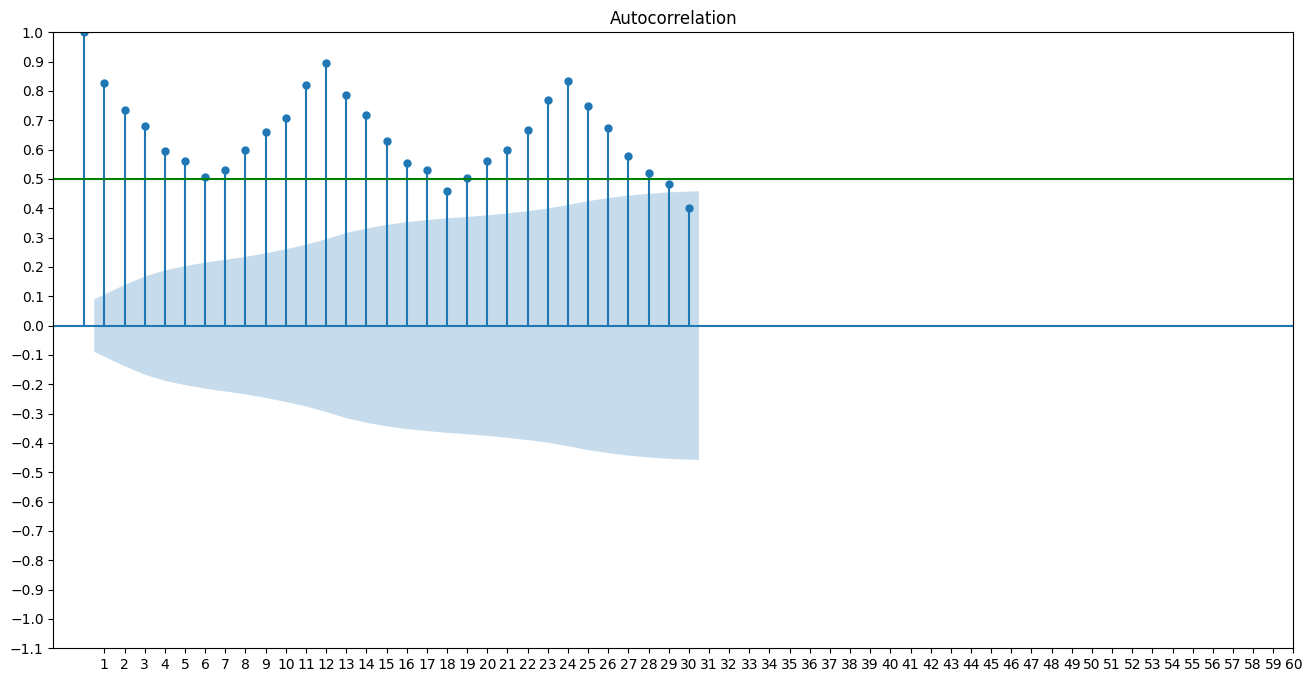

In [3]:
# inspect autocorrelation in the time series using ACF plot
# by default we look at correlation at 10 *log10(N) lags > 27 lags for our time series
fig, ax = plt.subplots(figsize=(16,8))
# use plot.acf with lags = 30 , see https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
plot_acf(df['value'], lags=30, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(-1.1, 1.1, 0.1))
plt.xticks(np.arange(1, 61, 1))
plt.axhline(y=0.5, color="green")
plt.show()

In [4]:
# check stationarity in time series using ADF test
from statsmodels.tsa.stattools import adfuller
df = pd.DataFrame(df).set_index('Date')
df.index = pd.DatetimeIndex(df.index).to_period('M')
# The null hypothesis of the ADF test is that the time series is non-stationary.
#So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and
#infer that the time series is indeed stationary.

#use adfuller() on 'value' column: see https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
result = adfuller(df['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.282661
p-value: 0.177621


Text(0.5, 1.0, 'ACF of second differencing data')

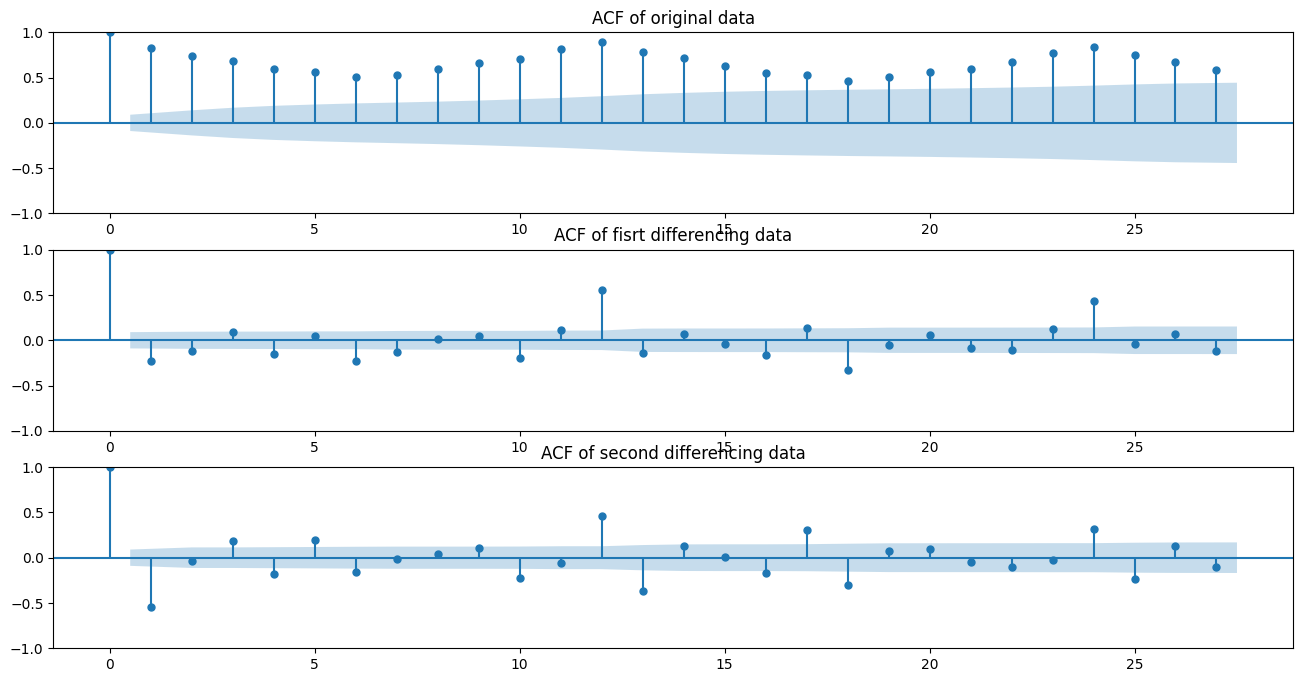

In [5]:
# tuning # tuning p, d, q 
# p is the order of the AR term
# q is the order of the MA term
# d is the order of differencing required to make the time series stationary
# starting with tuning  by plotting acf of original time series against first and second differencing:
figure, axis = plt.subplots(3, 1, figsize=(16,8))
plot_acf(df, ax=axis[0])
axis[0].set_title('ACF of original data')
# apply first differencing and drop nan values
plot_acf(df.diff().dropna(), ax=axis[1])
axis[1].set_title('ACF of fisrt differencing data')
# apply second differencing and drop nan values
plot_acf(df.diff().diff().dropna(), ax=axis[2])
axis[2].set_title('ACF of second differencing data')

Text(0.5, 1.0, 'PACF of 2-order differencing ')

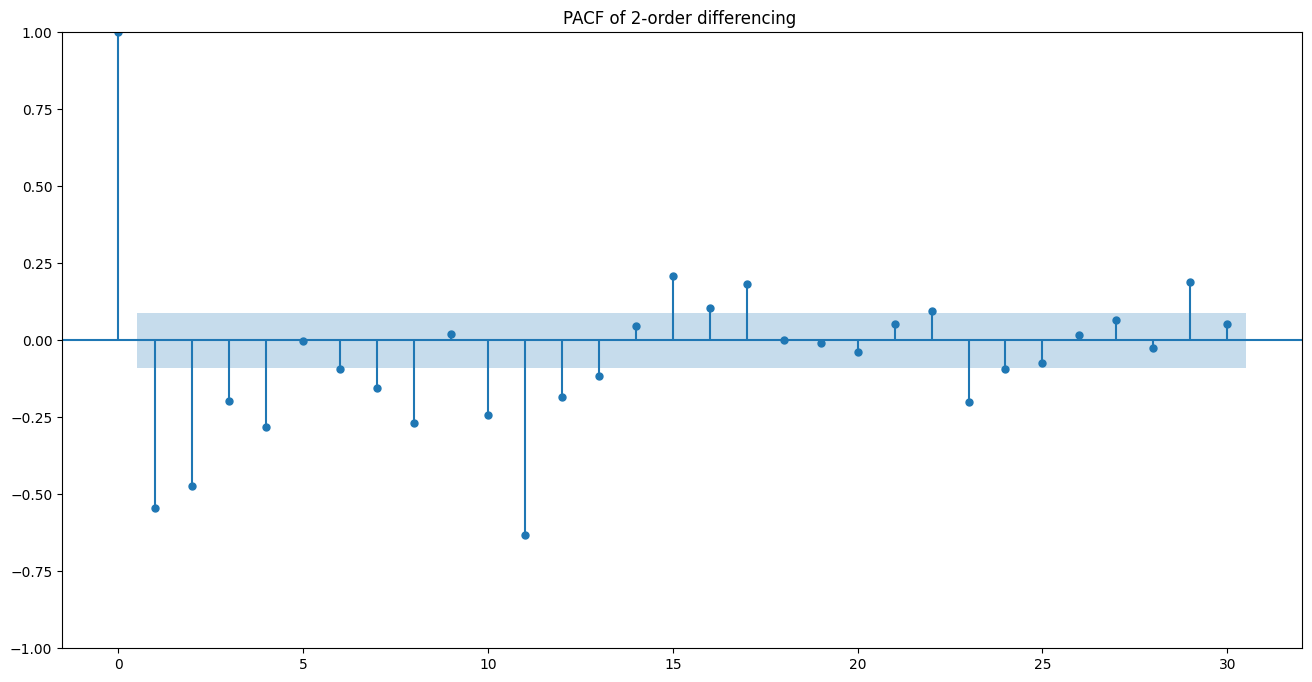

In [6]:
# AR term: p, You can find out the required number of AR terms
# by inspecting the Partial Autocorrelation (PACF) plot.
# Partial autocorrelation can be imagined as the correlation between the series and its lag,
# after excluding the contributions from the intermediate lags.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
fig, ax = plt.subplots(figsize=(16,8))
# apply pacf on the second differencing of the time series
# hint: use plot_pacf(), see https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html
plot_pacf(df.diff().diff().dropna(), lags=30, ax=ax)
ax.set_title('PACF of 2-order differencing ')
# pacf starts from lag 1, so we should look at the first lag in plot
# the blue region is the significance threshold
# there is cutoff at lag 1, so we choose p=1

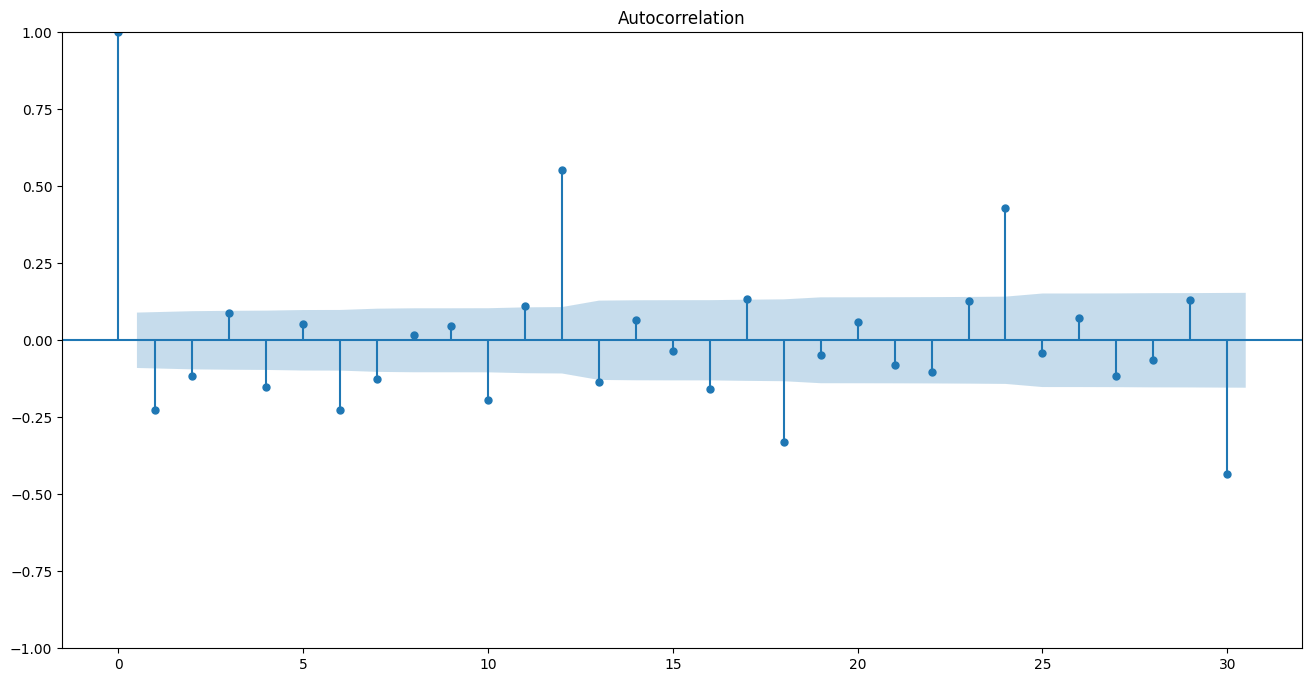

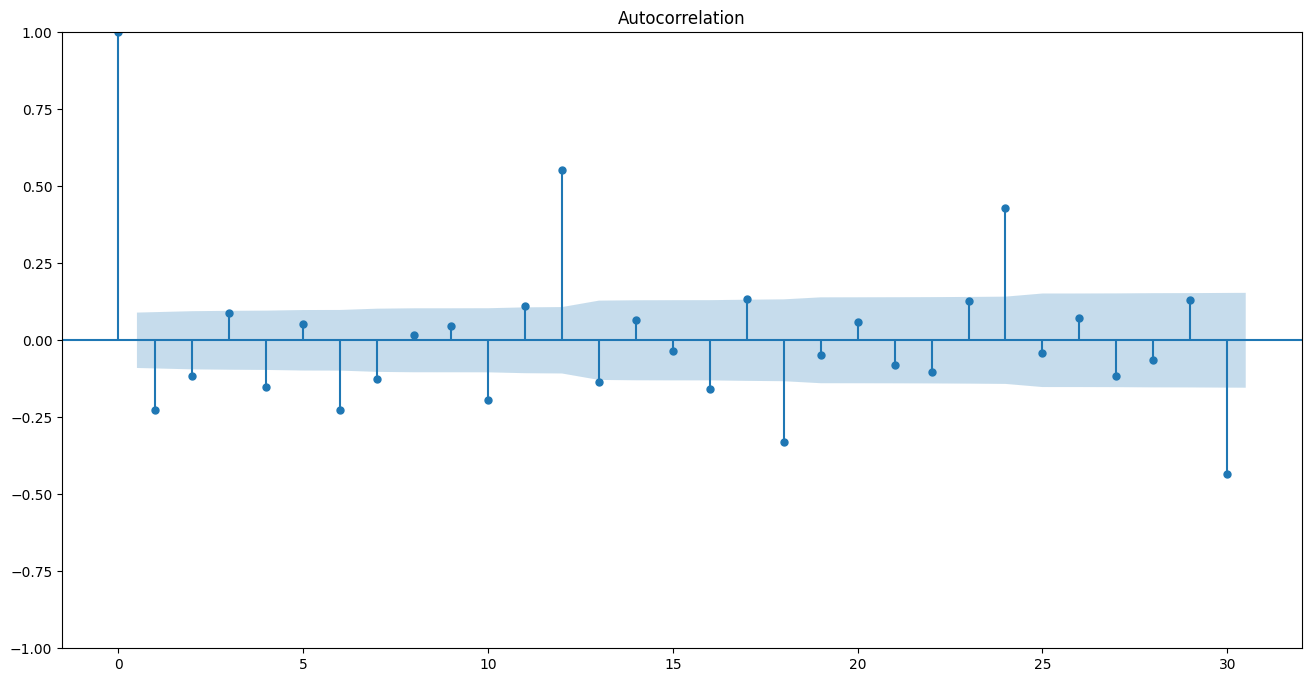

In [7]:
# MA term q :  from the ACF plot we decide the value of q.
# An MA term is technically, the error of the lagged forecast.
# The ACF tells how many MA terms (lags) are required to remove any autocorrelation in the series.

fig, ax = plt.subplots(figsize=(16,8))
# use plot_acf(), see above
plot_acf(df.diff().dropna(), lags=30, ax=ax)

In [8]:
# arima: order(p,d,q),  p is the order (number of time lags) of the autoregressive model
from statsmodels.tsa.arima.model import ARIMA

# apply ARIMA Model: ARIMA() with p,d,q value you obtained from the above plots
# see: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
model = ARIMA(df, order=(1,2,12))
# fit the model, see https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
model_fit = model.fit()
print(model_fit.summary())

c:\Projetos\time_series_ikileus\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  476
Model:                ARIMA(1, 2, 12)   Log Likelihood               -1953.966
Date:                Tue, 22 Oct 2024   AIC                           3935.932
Time:                        10:48:43   BIC                           3994.189
Sample:                    01-31-1956   HQIC                          3958.843
                         - 08-31-1995                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9839      0.020    -49.495      0.000      -1.023      -0.945
ma.L1         -0.6660      0.778     -0.856      0.392      -2.191       0.859
ma.L2         -1.2437      0.279     -4.456      0.0

c:\Projetos\time_series_ikileus\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


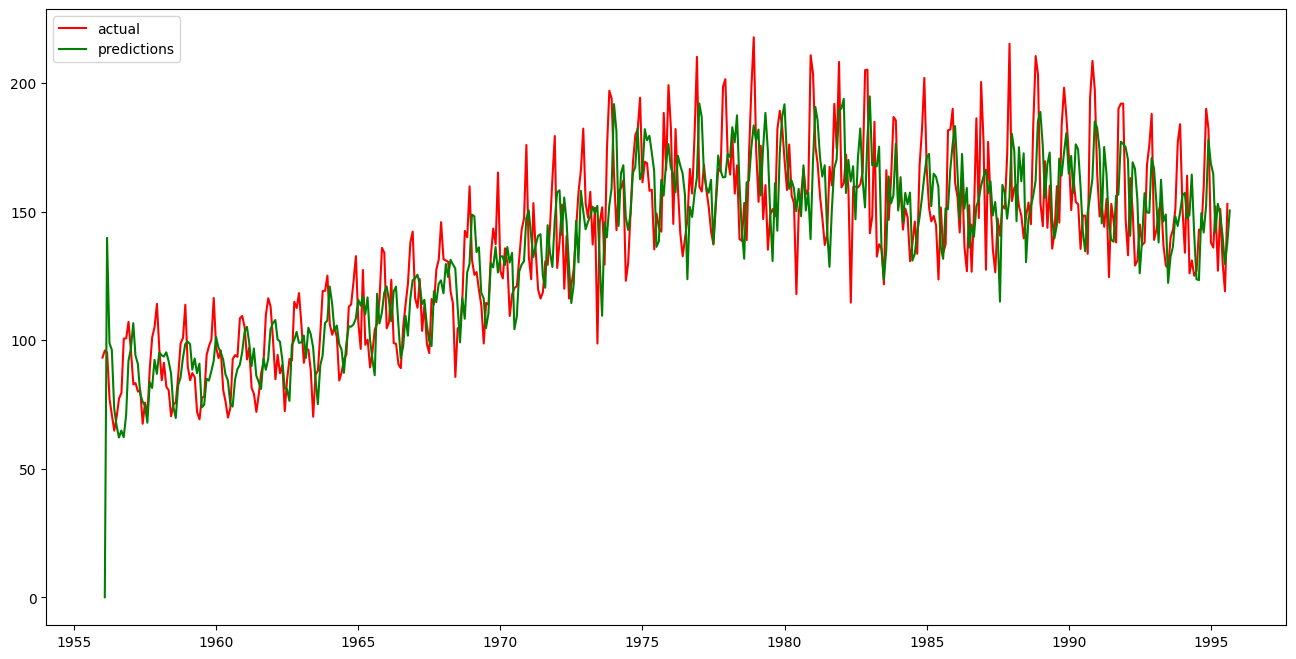

In [9]:
#plotting Actual vs Fitted
from sklearn.metrics import mean_absolute_percentage_error
fig, ax = plt.subplots(figsize=(16,8))
# in sample predictions(fitted values): After a model has been fit, predict() returns the fitted values.
# hint: use predict(), see https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html
pred= model_fit.predict()

df1 = df.to_timestamp()
plt.plot(df1, label ='actual',color='r')
plt.plot(pred,color='g',label= 'predictions')
plt.legend(loc="upper left")
plt.show()

In [10]:
# check prediction accuracy
mape = mean_absolute_percentage_error(df, pred)
mape

0.08883220697595468

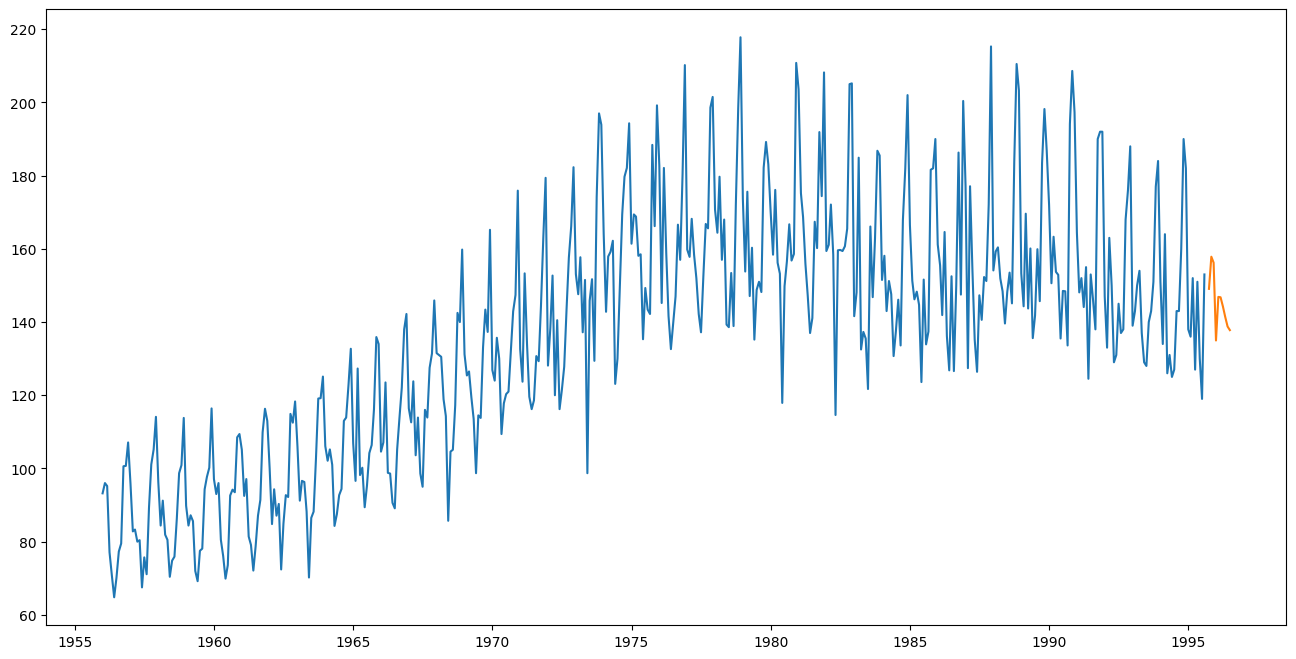

In [11]:
#out of samples forecasts, 10 steps 
# use forecast(), see https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.forecast.html

forecasts = model_fit.forecast(steps=10)
fig, ax = plt.subplots(figsize=(16,8))
# plot true values with forecasts
plt.plot(df1, label ='true data')
plt.plot(forecasts, label='forecasts')
plt.show()

In [12]:
# apply TBATS with two seasonality, 12, 24

from tbats import  TBATS

# box-cox transformation:a statistical technique that transforms your target variable
# so that your data closely resembles a normal distribution. This helps making the residuals of the model as normal as possible
# and thus leads to better forecasting performance

# n_jobs: How many jobs to run in parallel when fitting TBATS model.

# monthly and weekly seasonalities
 # with box_cox transformation 
estimator = TBATS(seasonal_periods=(12, 24), use_box_cox=True, n_jobs=12)
# box_cox transformation is disabled
estimator2 = TBATS(seasonal_periods=(12, 24), use_box_cox=False, n_jobs=12) 

In [13]:
#prepare train and validate sets: use < 1990 for training
df.index = pd.DatetimeIndex(df.index.to_timestamp()).to_period('M')

# split into train and validation data
y_train = df.loc[df.index < '1990-01-01']
y_valid = df.loc[df.index >= '1990-01-01']
len(y_valid)

68

In [14]:
# fit both TBATS model on training data 
#  see https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html#sktime.forecasting.tbats.TBATS.fit
fitted_model = estimator.fit(y_train)
fitted_model2 = estimator2.fit(y_train)


In [15]:
# create forecast horizon on the test data, use ForecastingHorizon(), see https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.base.ForecastingHorizon.html
# Forecast len(y_valid) steps ahead and compare with real temporal data
#see https://pypi.org/project/tbats/
h = len(y_valid)
# forecasts with box-cox
y_forecasted = fitted_model.forecast(steps=h)
# forecasts without box-cox
y_forecasted2 = fitted_model2.forecast(steps=h)


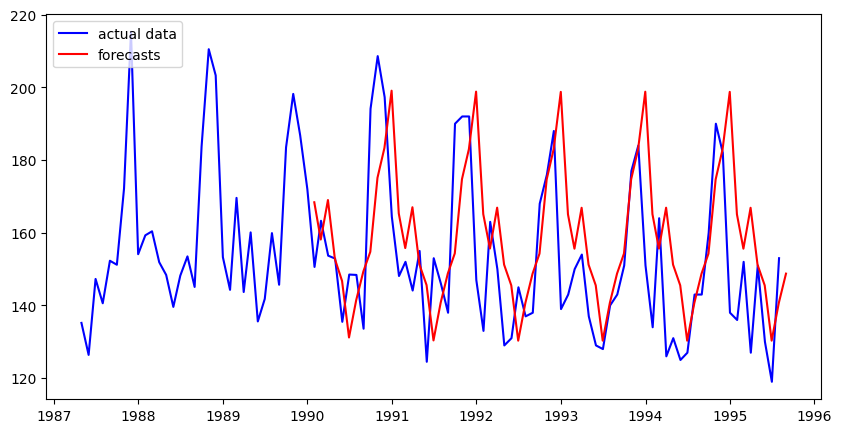

In [16]:
# plotting true against forecasts using the first model.
df_forecast= pd.DataFrame(data=y_forecasted, index=y_valid.index)
# convert the index of df to 'timestamp' format, use to_timestamp() with freq='M'
df.index = pd.DatetimeIndex(df.index.to_timestamp())

fig, ax = plt.subplots(figsize = (10,5))

plt.plot(df[-100:], label = 'actual data', color="blue" )
plt.plot(df_forecast, label= 'forecasts', color = 'red')
plt.legend(loc="upper left")
plt.show()

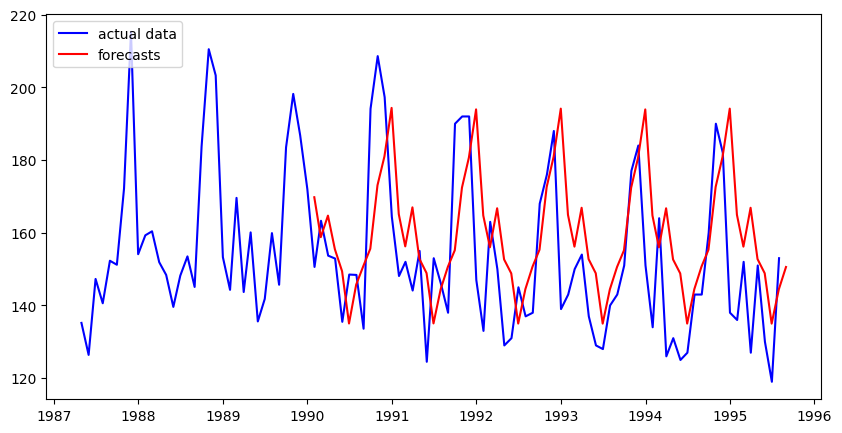

In [17]:
# plotting true against forecasts using the first model.

df_forecast2=pd.DataFrame(data=y_forecasted2, index=y_valid.index)


fig, ax = plt.subplots(figsize = (10,5))

plt.plot(df[-100:], label = 'actual data', color="blue")
plt.plot(df_forecast2, label= 'forecasts', color = 'red')
plt.legend(loc="upper left")
plt.show()

In [18]:
# calculate forecasting error between y_forecasted and y_valid, use  mean_absolute_percentage_error() 
from sklearn.metrics import mean_absolute_percentage_error

print('mean absolute percentage error on test data using :', mean_absolute_percentage_error(y_valid, y_forecasted))
print('mean absolute percentage error on test data using :', mean_absolute_percentage_error(y_valid, y_forecasted2))


mean absolute percentage error on test data using : 0.07485773025325834
mean absolute percentage error on test data using : 0.0772970208570452
